In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

from torchvision import datasets, transforms


# Welcome
### This notebook is for you only if you have never trained a NN, or done it with torch
In the rest of the tutorial you will see how Variational Autoencoders compare to traditional Autoencoders. However, both these models are based on Neural Networks, so it's necessary to first have an understanding of these. Here I will assume that you roughly know how they work, but you have never trained one.

First, you should know that the big goal is to optimize a set of parameters, distributed across different layers of neurons. The way to do this is Stochastic Gradient Descent, but it may be unclear how to optimize, let's say, the neurons in the first layer, from a loss function defined at the end. Or, better, it's easy to say how, but in practice it would be a pain to do it in practice. For this reason, we use Automatic Differentiation (also, it you're italian, you may have heard someone state "derivare è bovino, integrare è divino)

In [35]:
#define a function on a tensor
#Notice: the function has to be a scalar function for torch to do it automatically!
def f(x):
    print(x**2 + 2*x + 1)
    return torch.sum(x**2 + 2*x + 1)
#define a torch tensor
x = torch.tensor([1.,2.,3.,4.], requires_grad=True)
#apply the function to the tensor
y = f(x)
#now, the gradient of y with respect to x is:
print(f'Gradient of the function w.r.t. x:{x.grad}')
#the gradient is None because we haven't computed it yet
#to compute the gradient, we need to call the backward() method
y.backward()
#now, the gradient of y with respect to x is:
print(f'Gradient of the function w.r.t. x:{x.grad}')



tensor([ 4.,  9., 16., 25.], grad_fn=<AddBackward0>)
Gradient of the function w.r.t. x:None
Gradient of the function w.r.t. x:tensor([ 4.,  6.,  8., 10.])


In [36]:
#as you can imagine, this can work when we concatenate functions as well
#let's define a function that is a composition of two functions
def g(x):
    return x-2

#as before, let's define a tensor
x = torch.tensor([1.,2.,3.,4.], requires_grad=True)
#now weapply the composition of functions to the tensor
y = f(g(x))

y.backward()

print(f'Gradient of the function w.r.t. x:{x.grad}')

tensor([0., 1., 4., 9.], grad_fn=<AddBackward0>)
Gradient of the function w.r.t. x:tensor([0., 2., 4., 6.])


### Ok, now we can move to NNs
Basically, we can see a NN as a concatenation of function that ultimately enters the Loss function (which is, coincidentally, a scalar one), for which we can then have the gradient w.r.t. all the parameters in the network. I'll be less pedantic from now on, as it gets only a matter of implementation

In [37]:
class Net(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x
    
#download the MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)

#load only part of the dataset: 10000 training images and 1000 test images
train_dataset = torch.utils.data.Subset(train_dataset, range(10000))
test_dataset = torch.utils.data.Subset(test_dataset, range(1000))

#create a loader, an object that can iterate over the dataset
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=len(test_dataset), shuffle=False)

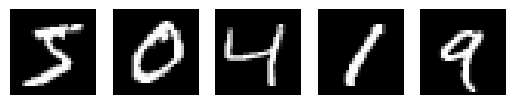

In [38]:
fig, ax = plt.subplots(1, 5)
for i in range(5):
    ax[i].imshow(train_dataset[i][0][0], cmap='gray')
    ax[i].axis('off')

In [46]:
#initialize a Net object
net = Net(28*28, 100, 10)
#initialize an optimizer
optimizer = optim.SGD(net.parameters(), lr=0.05)
#define the loss function
criterion = nn.CrossEntropyLoss(reduction='mean')

n_epochs = 10
#train on the dataset
for epoch in range(n_epochs):
    for batch_idx, (data, target) in enumerate(train_loader):
        #flatten the images
        data = data.view(-1, 28*28)
        #set the gradients to zero
        optimizer.zero_grad()
        #forward pass
        output = net(data)
        #compute the loss
        loss = criterion(output, target)
        #backward pass
        loss.backward()
        #update the weights
        optimizer.step()
        #print some info
        
    # Evaluation phase
    net.eval()  # Set the network to evaluation mode

    # Calculate training loss over the entire training set
    train_loss = 0
    train_correct = 0
    with torch.no_grad():  # No need to track gradients
        for train_data, train_target in train_loader:
            train_data = train_data.view(-1, 28*28)
            train_output = net(train_data)
            train_loss += criterion(train_output, train_target).item()
            train_correct += torch.sum(torch.argmax(train_output, dim=1) == train_target).item()
    train_loss /= len(train_loader)
    train_accuracy = train_correct / len(train_dataset)

    # Calculate test loss
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for test_data, test_target in test_loader:
            test_data = test_data.view(-1, 28*28)
            test_output = net(test_data)
            test_loss += criterion(test_output, test_target).item()
            correct += torch.sum(torch.argmax(test_output, dim=1) == test_target).item()
    test_loss /= len(test_loader)
    test_accuracy = correct / len(test_dataset)

    # Print epoch information
    print(f'Epoch {epoch}/{n_epochs} - Train Loss: {train_loss}, Test Loss: {test_loss}, Train Accuracy: {train_accuracy}  Test Accuracy: {test_accuracy}')

Epoch 0/10 - Train Loss: 0.70196015591834, Test Loss: 0.7894030213356018, Train Accuracy: 0.8469  Test Accuracy: 0.81
Epoch 1/10 - Train Loss: 0.4527862457333097, Test Loss: 0.5267124176025391, Train Accuracy: 0.8816  Test Accuracy: 0.851
Epoch 2/10 - Train Loss: 0.37544838799412844, Test Loss: 0.4405045807361603, Train Accuracy: 0.8995  Test Accuracy: 0.872
Epoch 3/10 - Train Loss: 0.33342216339460606, Test Loss: 0.3954382836818695, Train Accuracy: 0.9086  Test Accuracy: 0.892
Epoch 4/10 - Train Loss: 0.3035173810021892, Test Loss: 0.3720663785934448, Train Accuracy: 0.9175  Test Accuracy: 0.895
Epoch 5/10 - Train Loss: 0.29301849197430213, Test Loss: 0.36363834142684937, Train Accuracy: 0.9197  Test Accuracy: 0.892
Epoch 6/10 - Train Loss: 0.2683253056209558, Test Loss: 0.33881044387817383, Train Accuracy: 0.9258  Test Accuracy: 0.902
Epoch 7/10 - Train Loss: 0.26327157186664596, Test Loss: 0.33944249153137207, Train Accuracy: 0.9269  Test Accuracy: 0.899
Epoch 8/10 - Train Loss: 0.2

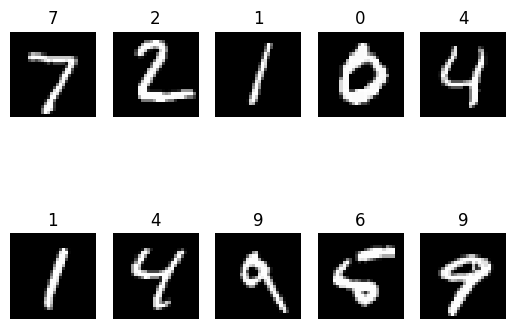

In [47]:
#plot a few examples on the test set
fig, ax = plt.subplots(2, 5)
for i in range(5):
    ax[0][i].imshow(test_dataset[i][0][0], cmap='gray')
    ax[0][i].axis('off')
    ax[0][i].set_title(f'{torch.argmax(net(test_dataset[i][0].view(-1, 28*28)))}')
    ax[1][i].imshow(test_dataset[i+5][0][0], cmap='gray')
    ax[1][i].axis('off')
    ax[1][i].set_title(f'{torch.argmax(net(test_dataset[i+5][0].view(-1, 28*28)))}')


